In [163]:
import math
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
L = 40  # side length
N = L ** 2  # number of sites
q = 5  # number of states per site
J = 1  # ferromagnetic interaction strength
avgs = []
en_history = {}
mag_history = {}
prob_history = {}
n_accepted = {}

## Function Definitions

In [165]:
def energy_nn(sigma, J):
    en = 0
    for i in range(L):
        for j in range(L):
            if sigma[i][j] == sigma[i][(j + 1) % L]: en -= J
            if sigma[i][j] == sigma[(i + 1) % L][j]: en -= J
    return en


# controlla ordine i, j corretto
neighs_cache = [[((i, (j + 1) % L), (i, (j - 1) % L), ((i + 1) % L, j), ((i - 1) % L, j)) for j in range(L)] for i in
                range(L)]


def delta_energy_nn(sigma, J, i, j, new_q):
    # i, j = ind
    neighs = neighs_cache[i][j]

    delta_en = 0
    for x, y in neighs:
        if sigma[i][j] == sigma[x][y]:
            delta_en += J
        if new_q == sigma[x][y]:
            delta_en -= J
    return delta_en


# PRECOMP = 10 ** 6
# precomputed_indexes = [random.randint(0, N - 1) for x in range(PRECOMP)]
# precomp_index = 0


def propose_flip(sigma, J):
    # global precomp_index, precomputed_indexes

    # if precomp_index >= PRECOMP:
    #     precomputed_indexes = [random.randint(0, N - 1) for x in range(PRECOMP)]
    #     precomp_index = 0
    #
    # index = precomputed_indexes[precomp_index]
    # precomp_index += 1

    index = random.randint(0, N - 1)
    index1, index2 = index // L, index % L

    x = random.randint(0, q - 1)
    while x == sigma[index1][index2]:
        x = random.randint(0, q - 1)
    return index1, index2, x


# metropolis acceptance with symmetric proposal. returns a Boolean
def metropolis(delta_en, t):
    if delta_en < 0:
        return True
    if random.uniform(0, 1) < math.exp(- delta_en / t):
        return True
    return False

In [166]:
# metropolis simulation. Accept parameters specifying system and simulation config. Store results in global dicts.
random.seed(42)


def MCMC(L, q, t, nstep, burnin, J=1, freq=1000, keep_history=True):
    # random initial configuration
    # sigma = np.random.randint(0, q, (L, L))

    sigma = [[random.randint(0, q) for _1 in range(L)] for _2 in range(L)]
    en = energy_nn(sigma, J)

    # run a few steps to reach stationarity
    for istep in range(burnin):
        # propose random flip
        ind1, ind2, q_new = propose_flip(sigma, J)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, ind1, ind2, q_new)
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[ind1][ind2]
            sigma[ind1][ind2] = q_new
            # update energy
            en += delta_en

    # prepare to store metrics
    # mag_history[t] = np.zeros((q, nstep + 1))
    mag_history[t] = []
    # mag_history_internal = [[0 for x in range(q)] for y in range(nstep + 1)]
    mag_history_internal = [None]
    mag_history_internal[0] = list(np.bincount(np.array(sigma).reshape(-1), minlength=q))
    # print(mag_history_internal[0])
    prob_history[t] = []
    en_history[t] = []
    n_accepted[t] = 0

    avg_t = 0
    # main loop
    for istep in range(nstep):
        # propose random flip
        ind1, ind2, q_new = propose_flip(sigma, J)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, ind1, ind2, q_new)
        # update probability history
        if keep_history:
            if delta_en > 0:
                prob_history[t].append(math.exp(- delta_en / t))
            else:
                prob_history[t].append(1)
        # prepare magnetization update
        # mag_history[t][:, istep + 1] = mag_history[t][:, istep]
        # mag_history_internal[istep + 1] = mag_history_internal[istep].copy()
        mag_history_internal.append(mag_history_internal[istep].copy())
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[ind1][ind2]
            sigma[ind1][ind2] = q_new
            n_accepted[t] += 1
            # update energy
            en += delta_en
            # update magnetization history
            mag_history_internal[istep + 1][q_old] -= 1
            mag_history_internal[istep + 1][q_new] += 1
        # update energy history
        if keep_history: en_history[t].append(en)

        avg_t += en
        if istep % freq == 3:
            # temp = np.array(mag_history_internal[-freq:])
            # mag_history[t].append(temp.mean(axis=1))
            temp_mag = [0] * q
            # print(mag_history_internal[-freq:])
            # print(istep, freq)
            for v in mag_history_internal[- freq:]:
                for ind, val in enumerate(v):
                    temp_mag[ind] += val
            temp_mag = [x / len(mag_history_internal[-freq:]) for x in temp_mag]
            mag_history[t].append(temp_mag)
    # print(en_history)
    # en_history[t] = np.array(en_history[t])
    prob_history[t] = np.array(prob_history[t])
    # avgs.append(sum(en_history[t]) / len(en_history[t]))
    avgs.append(avg_t / nstep)

    if not keep_history:
        del en_history[t]  # memory reason, keep only average
        # maybe extract features also from prob_history and delete that too
        del prob_history[t]
        del mag_history_internal  # not used at the moment so freeing memory


## Simulations q=4

In [174]:
q = 4  # number of states per site
J = 1  # ferromagnetic interaction strength
avgs = []
en_history = {}
mag_history = {}
prob_history = {}
n_accepted = {}
burnin = 3 * 10 ** 6
nstep = 10 ** 7

# temps for q = 5
temps = [0.3, 0.7, 0.75, 0.78, 0.8, 0.82, 0.84, 0.87, 0.9, 0.95, 1.0, 1.1, 1.2, 1.5]

tempo = time.time()
for t in temps:
    print(f'temperature: {t}')
    MCMC(L, q, t, nstep, burnin, J, keep_history=False)  # seed 42
    print(f"Passed: {time.time() - tempo}")
    tempo = time.time()

temperature: 0.3
Passed: 15.338194131851196
temperature: 0.7
Passed: 15.941779136657715
temperature: 0.75
Passed: 16.1809344291687
temperature: 0.78
Passed: 16.62657904624939
temperature: 0.8
Passed: 16.844699144363403
temperature: 0.82
Passed: 17.011924743652344
temperature: 0.84
Passed: 17.71054458618164
temperature: 0.87
Passed: 18.39896583557129
temperature: 0.9
Passed: 18.88425040245056
temperature: 0.95
Passed: 21.08759593963623
temperature: 1.0
Passed: 22.887004375457764
temperature: 1.1
Passed: 22.95488476753235
temperature: 1.2
Passed: 24.588343381881714
temperature: 1.5
Passed: 30.232364654541016


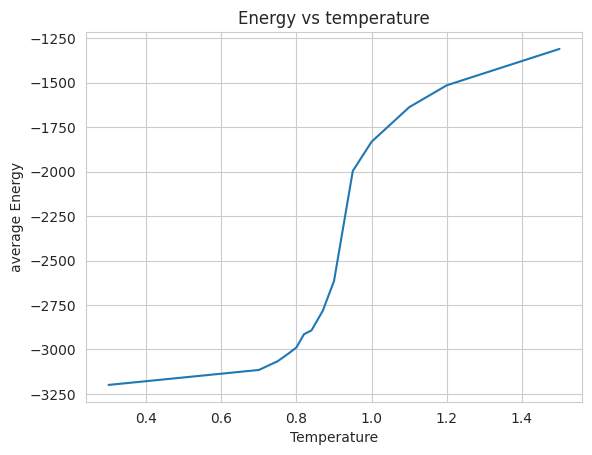

In [175]:
plt.plot(temps, avgs)
plt.xlabel('Temperature')
plt.ylabel('average Energy')
plt.title('Energy vs temperature')
plt.show()

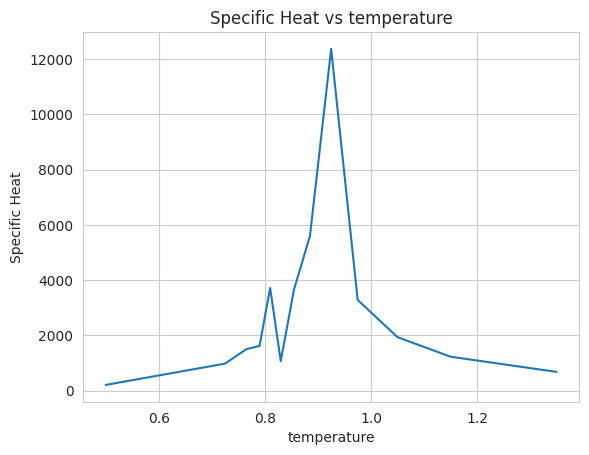

In [176]:
spec_heats = [(avgs[i + 1] - avgs[i]) / (temps[i + 1] - temps[i]) for i in range(0, len(temps) - 1)]
avg_temps = [(temps[i + 1] + temps[i]) / 2 for i in range(0, len(temps) - 1)]

plt.plot(avg_temps, spec_heats)
plt.ylabel('Specific Heat')
plt.xlabel('temperature')
plt.title('Specific Heat vs temperature')
plt.show()

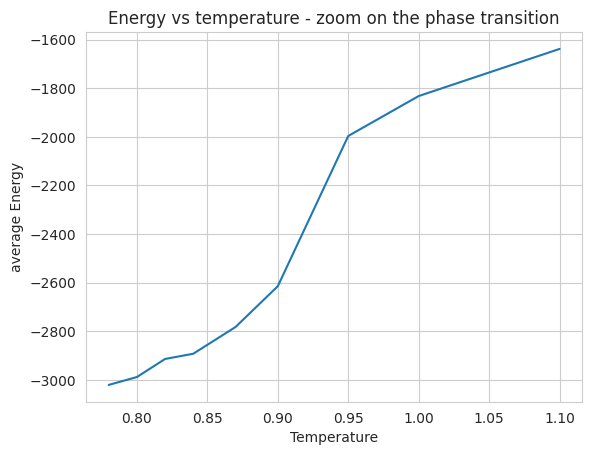

In [177]:
plt.plot(temps[3:-2], avgs[3:-2])
plt.xlabel('Temperature')
plt.ylabel('average Energy')
plt.title('Energy vs temperature - zoom on the phase transition')
plt.show()

## Simulation q=5

In [182]:
q = 5  # number of states per site
J = 1  # ferromagnetic interaction strength
avgs = []
en_history = {}
mag_history = {}
prob_history = {}
n_accepted = {}
# burnin = 7 * 10 ** 5
burnin = 4 * 10 ** 6
# nstep = 5 * 10 ** 6
nstep = 10 ** 7

# temps for q = 5
temps = [0.3, 0.7, 0.75, 0.8, 0.83, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.5]

tempo = time.time()
for t in temps:
    print(f'temperature: {t}')
    MCMC(L, q, t, nstep, burnin, J, keep_history=False)  # seed 42
    print(f"Passed: {time.time() - tempo}")
    tempo = time.time()

temperature: 0.3
Passed: 32.95575928688049
temperature: 0.7
Passed: 19.6448872089386
temperature: 0.75
Passed: 19.02177882194519
temperature: 0.8
Passed: 20.233497619628906
temperature: 0.83
Passed: 20.373027801513672
temperature: 0.85
Passed: 21.62753200531006
temperature: 0.9
Passed: 23.90155577659607
temperature: 0.95
Passed: 25.40794014930725
temperature: 1.0
Passed: 26.51108479499817
temperature: 1.1
Passed: 28.04947853088379
temperature: 1.2
Passed: 28.557329416275024
temperature: 1.5
Passed: 31.446666479110718


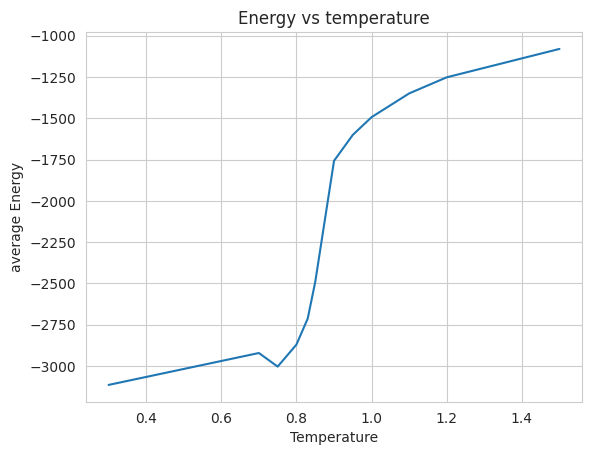

In [183]:
plt.plot(temps, avgs)
plt.xlabel('Temperature')
plt.ylabel('average Energy')
plt.title('Energy vs temperature')
plt.show()

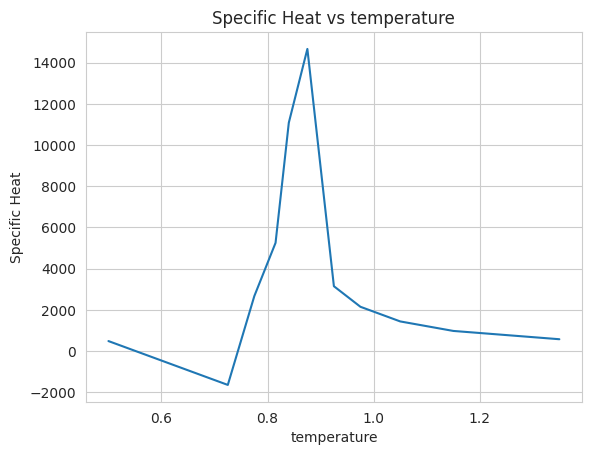

In [184]:
spec_heats = [(avgs[i + 1] - avgs[i]) / (temps[i + 1] - temps[i]) for i in range(0, len(temps) - 1)]
avg_temps = [(temps[i + 1] + temps[i]) / 2 for i in range(0, len(temps) - 1)]

plt.plot(avg_temps, spec_heats)
plt.ylabel('Specific Heat')
plt.xlabel('temperature')
plt.title('Specific Heat vs temperature')
plt.show()

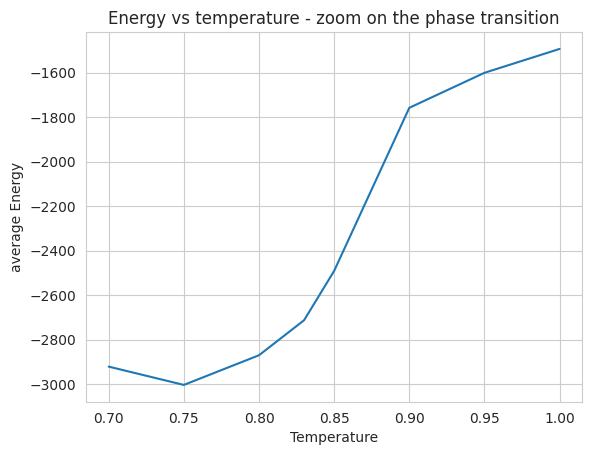

In [185]:
left, right = 1, -3
plt.plot(temps[left:right], avgs[left:right])
plt.xlabel('Temperature')
plt.ylabel('average Energy')
plt.title('Energy vs temperature - zoom on the phase transition')
plt.show()

## Analysis of a single run

In [167]:
t = 0.7
avgs = []
en_history = {}
mag_history = {}
prob_history = {}
n_accepted = {}

# burnin = 5 * 10 ** 5
burnin = 10 ** 5
nstep = 10 ** 7
MCMC(L, q, t, nstep, burnin, J, keep_history=True)


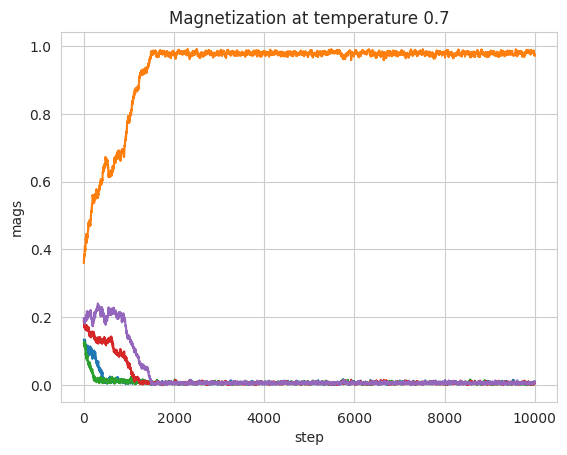

In [168]:
# print magnetization evolution in time
mag_history[t] = np.array(mag_history[t]).T

for i in range(q):
    plt.plot(mag_history[t][i] / N, label=i)
plt.xlabel('step')
plt.ylabel('mags')
plt.title(f"Magnetization at temperature {t}")
plt.show()
# ci starebbe dire che qui il behaviour non è ancora caotico, a .91 L=40 vince una magnetizzazione anche se con tanto rumore.
# a .92 invece è già quasi caotico (tende a vincere una m ma a tratti si flippano e cmq toccano il 66% di solito) q=4

In [169]:
window_size = 3000
kernel = np.ones(window_size) / window_size
# smoothed_en = np.convolve(en_history[t], kernel, mode='valid')

Average energy: -3045.9508537


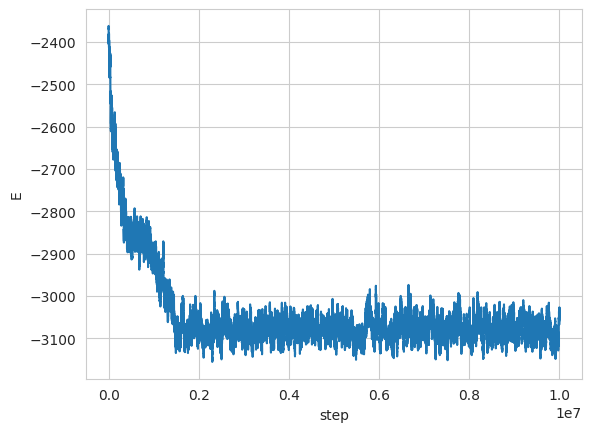

In [170]:

plt.plot(en_history[t])
plt.xlabel("step")
plt.ylabel("E")

# print(f'Average energy: {en_history[t].mean()}')
print(f'Average energy: {sum(en_history[t]) / len(en_history[t])}')
plt.show()

In [171]:
# convolve acceptance probabilities with a kernel to improve visualization

smoothed_probs = np.convolve(prob_history[t], kernel, mode='valid')

Fraction of accepted proposals: 0.0280835


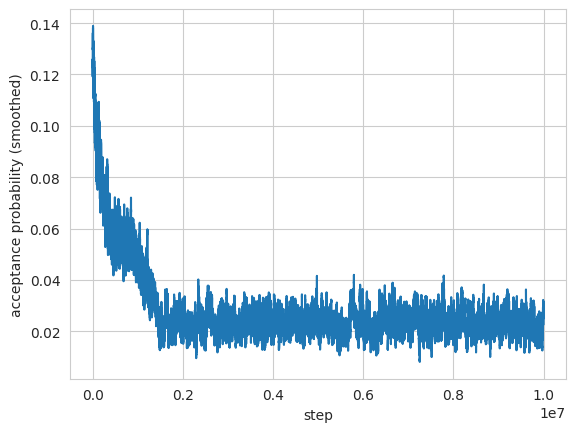

In [172]:
# plot
plt.plot(smoothed_probs)
plt.xlabel('step')
plt.ylabel('acceptance probability (smoothed)')
# plt.yscale('log')

print(f"Fraction of accepted proposals: {n_accepted[t] / nstep}")
plt.show()


In [173]:
# t=.92 è il più interessante (o cmq in quella zona) poiché intorno alla transizione ci sono dei flip nelle probabilità e si vedono dei trend
# del tipo che il sistema è in fasi diverse e quindi la acceptance probability anche fa su e giù
# è abbastanza sensibile al seed iniziale